# RETAIL ANALYSIS WITH WALMART SALES DATA

## 1. Business problem

In this notebook, we are going to use time series analysis to forecast future demand for a Walmart store.

Data source: https://www.kaggle.com/datasets/rutuspatel/retail-analysis-with-walmart-sales-data?resource=download

## 2. Data preprocessing

In [84]:
#Import required packages
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from dmba import regressionSummary

In [85]:
#Load, convert walmart data for time series analysis
sales = pd.read_csv('sales.csv', squeeze=True)

C:\Users\haleh\AppData\Local\Temp\ipykernel_13420\1185429985.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  sales = pd.read_csv('sales.csv', squeeze=True)


In [86]:
sales

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [87]:
#Filter Store 1 data
sales_1 = sales[sales['Store'] == 1]
sales_1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
138,1,28-09-2012,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,05-10-2012,1670785.97,0,68.55,3.617,223.181477,6.573
140,1,12-10-2012,1573072.81,0,62.99,3.601,223.381296,6.573
141,1,19-10-2012,1508068.77,0,67.97,3.594,223.425723,6.573


In [88]:
#Select only the 'Date' and 'Weekly_Sales' columns
sales_1 = sales_1[['Date', 'Weekly_Sales']]
sales_1

,Date,Weekly_Sales
0,05-02-2010,1643690.90
1,12-02-2010,1641957.44
2,19-02-2010,1611968.17
3,26-02-2010,1409727.59
4,05-03-2010,1554806.68
...,...,...
138,28-09-2012,1437059.26
139,05-10-2012,1670785.97
140,12-10-2012,1573072.81
141,19-10-2012,1508068.77


In [89]:
sales_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [90]:
#Convert column 'Date' to date data type
sales_1['Date'] = pd.to_datetime(sales_1['Date'], format='%d-%m-%Y')
sales_1

C:\Users\haleh\AppData\Local\Temp\ipykernel_13420\1002919613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_1['Date'] = pd.to_datetime(sales_1['Date'], format='%d-%m-%Y')


,Date,Weekly_Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68
...,...,...
138,2012-09-28,1437059.26
139,2012-10-05,1670785.97
140,2012-10-12,1573072.81
141,2012-10-19,1508068.77


## 3. Data modelling

In [91]:
#Convert to time series
sales_series = pd.Series(sales_1.Weekly_Sales.values, name='Sales', index=sales_1.Date)
sales_series

Date
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68
                 ...    
2012-09-28    1437059.26
2012-10-05    1670785.97
2012-10-12    1573072.81
2012-10-19    1508068.77
2012-10-26    1493659.74
Name: Sales, Length: 143, dtype: float64

Text(0, 0.5, 'Weekly Sales')

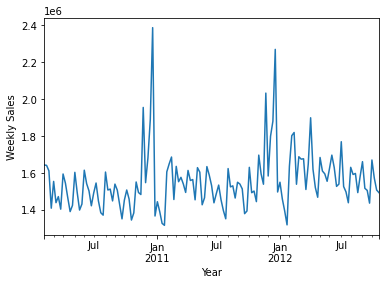

In [92]:
#Visualize the data
sales_series.plot(legend=False)
plt.xlabel('Year'); plt.ylabel('Weekly Sales')

In [93]:
#Add 'trend' to the dataset
sales_1 = tsatools.add_trend(sales_series, trend='ct')
sales_1

,Sales,const,trend
Date,,,
2010-02-05,1643690.90,1.0,1.0
2010-02-12,1641957.44,1.0,2.0
2010-02-19,1611968.17,1.0,3.0
2010-02-26,1409727.59,1.0,4.0
2010-03-05,1554806.68,1.0,5.0
...,...,...,...
2012-09-28,1437059.26,1.0,139.0
2012-10-05,1670785.97,1.0,140.0
2012-10-12,1573072.81,1.0,141.0


### Linear trend

In [94]:
#Fit a linear model
sales_linear = sm.ols(formula='Sales ~ trend', data=sales_1).fit()

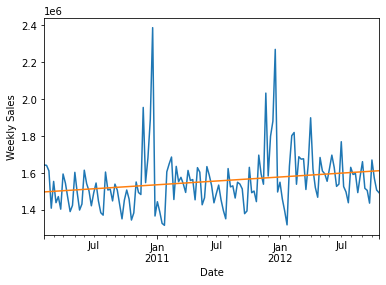

In [95]:
#Plot the time series
ax = sales_series.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Weekly Sales')
sales_linear.predict(sales_1).plot(ax=ax)
plt.show()

Does not fit the data well.

### Exponential Trend

In [96]:
#Fit an Exponential model
sales_expo = sm.ols(formula='np.log(Sales) ~ trend', data=sales_1).fit()

In [97]:
sales_expo.predict(sales_1)

Date
2010-02-05    14.215583
2010-02-12    14.216105
2010-02-19    14.216628
2010-02-26    14.217150
2010-03-05    14.217673
                ...    
2012-09-28    14.287685
2012-10-05    14.288208
2012-10-12    14.288730
2012-10-19    14.289253
2012-10-26    14.289775
Length: 143, dtype: float64

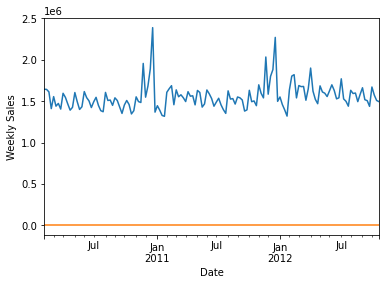

In [98]:
#Plot the time series
ax = sales_series.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Weekly Sales')
sales_expo.predict(sales_1).plot(ax=ax)
plt.show()

### Polynomial Trend

In [99]:
#Fit a polynomial trend model
sales_poly = sm.ols(formula='Sales ~ trend + np.square(trend)', data=sales_1).fit()

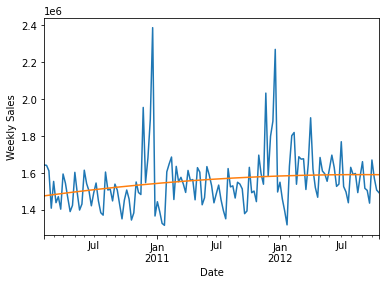

In [100]:
#Plot the time series
ax = sales_series.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Weekly Sales')
sales_poly.predict(sales_1).plot(ax=ax)
plt.show()

Fit a bit better but still not good.

### Handling Seasonality

In [101]:
#Add seasonality
sales_1 = tsatools.add_trend(sales_series, trend='c')
sales_1['Month'] = sales_1.index.month

In [102]:
sales_1

,Sales,const,Month
Date,,,
2010-02-05,1643690.90,1.0,2
2010-02-12,1641957.44,1.0,2
2010-02-19,1611968.17,1.0,2
2010-02-26,1409727.59,1.0,2
2010-03-05,1554806.68,1.0,3
...,...,...,...
2012-09-28,1437059.26,1.0,9
2012-10-05,1670785.97,1.0,10
2012-10-12,1573072.81,1.0,10


In [103]:
#Fit a seasonality model
sales_season = sm.ols(formula='Sales ~ C(Month)', data=sales_1).fit()

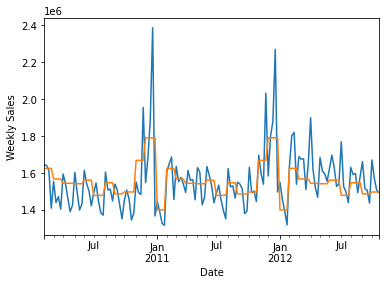

In [104]:
#Plot the time series
ax = sales_series.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Weekly Sales')
sales_season.predict(sales_1).plot(ax=ax)
plt.show()

Fit the data much better comparing to polynomial trend and linear trend.

### Seasonality, trend, and quadratic trend

In [105]:
#Add seasonality, trend, and quadratic trend
sales_1 = tsatools.add_trend(sales_series, trend='ct')
sales_1['Month'] = sales_1.index.month
sales_1

,Sales,const,trend,Month
Date,,,,
2010-02-05,1643690.90,1.0,1.0,2
2010-02-12,1641957.44,1.0,2.0,2
2010-02-19,1611968.17,1.0,3.0,2
2010-02-26,1409727.59,1.0,4.0,2
2010-03-05,1554806.68,1.0,5.0,3
...,...,...,...,...
2012-09-28,1437059.26,1.0,139.0,9
2012-10-05,1670785.97,1.0,140.0,10
2012-10-12,1573072.81,1.0,141.0,10


In [106]:
#Fit a combined trend and seasonality model
sales_trendseason = sm.ols(formula='Sales ~ trend + np.square(trend) + C(Month)', data=sales_1).fit()

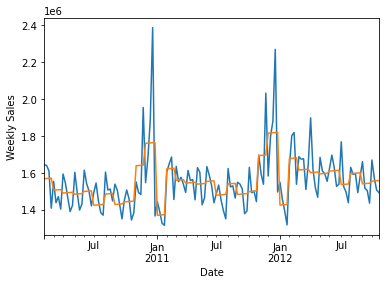

In [107]:
#Plot the time series
ax = sales_series.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Weekly Sales')
sales_trendseason.predict(sales_1).plot(ax=ax)
plt.show()

### Centered moving average and Trailing moving average

In [108]:
# Centered moving average with window size = 12
ma_centered = sales_series.rolling(12, center=True).mean()
# Trailing moving average with window size = 12
ma_trailing = sales_series.rolling(12).mean()


In [109]:
#Shift the average by one time unit to get the next day predictions
ma_centered = pd.Series(ma_centered[:-1].values, index=ma_centered.index[1:])
ma_trailing = pd.Series(ma_trailing[:-1].values, index=ma_trailing.index[1:])

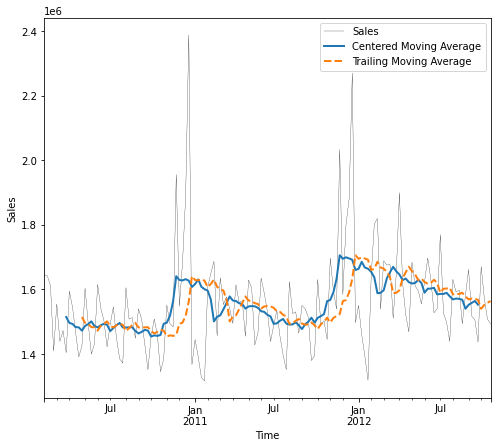

In [110]:
#Plot the time series
fig, ax = plt.subplots(figsize=(8, 7))
ax = sales_series.plot(ax=ax, color='black', linewidth=0.25)
ma_centered.plot(ax=ax, linewidth=2)
ma_trailing.plot(ax=ax, style='--', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.legend (['Sales','Centered Moving Average', 'Trailing Moving Average'])
plt.show()

Simple Moving Average is not actually useful for series that has trend and seasonality like our dataset.

### Exponential smoothing

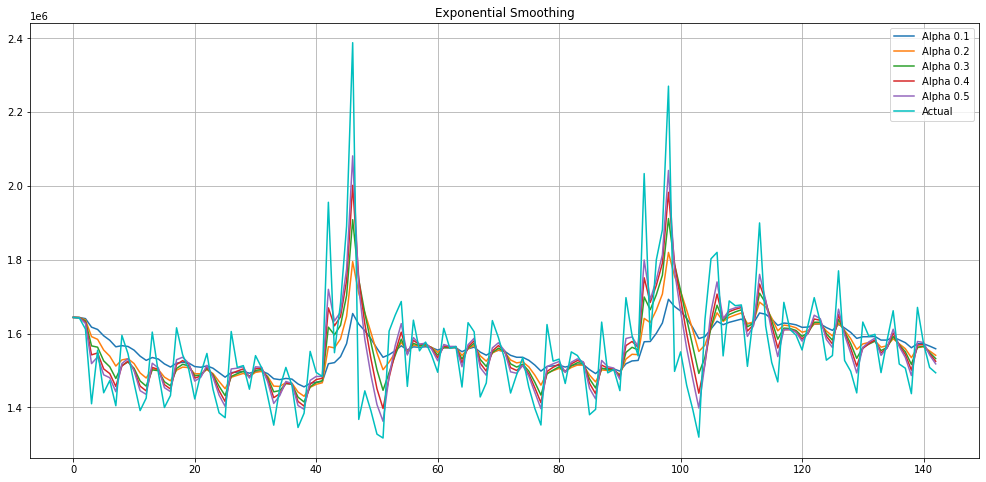

In [59]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(sales_1.Sales, [0.1, 0.2, 0.3, 0.4, 0.5])

Alpha value = 0.5 provides more accurate prediction outcomes and we can use it to forecast future demand for the Walmart store.

### Reference

https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775